# Explore here

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pickle import dump


In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.sample(10, random_state=42)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,58,33,190,34.0,0.430,43,0
324,2,112,75,32,0,35.7,0.148,21,0
624,2,108,64,0,0,30.8,0.158,21,0
690,8,107,80,0,0,24.6,0.856,34,0
473,7,136,90,0,0,29.9,0.210,50,0
204,6,103,72,32,190,37.7,0.324,55,0
97,1,71,48,18,76,20.4,0.323,22,0
336,0,117,0,0,0,33.8,0.932,44,0
568,4,154,72,29,126,31.3,0.338,37,0
148,5,147,78,0,0,33.7,0.218,65,0


In [39]:
df_interim = (
    df
    .copy()
    .set_axis(
        df.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop_duplicates().reset_index(drop = True))
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
df = df_interim.copy()


In [44]:
display(df.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
bloodpressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skinthickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
diabetespedigreefunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [45]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2024)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 529 to 648
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               614 non-null    int64  
 1   glucose                   614 non-null    int64  
 2   bloodpressure             614 non-null    int64  
 3   skinthickness             614 non-null    int64  
 4   insulin                   614 non-null    int64  
 5   bmi                       614 non-null    float64
 6   diabetespedigreefunction  614 non-null    float64
 7   age                       614 non-null    int64  
 8   outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.0 KB


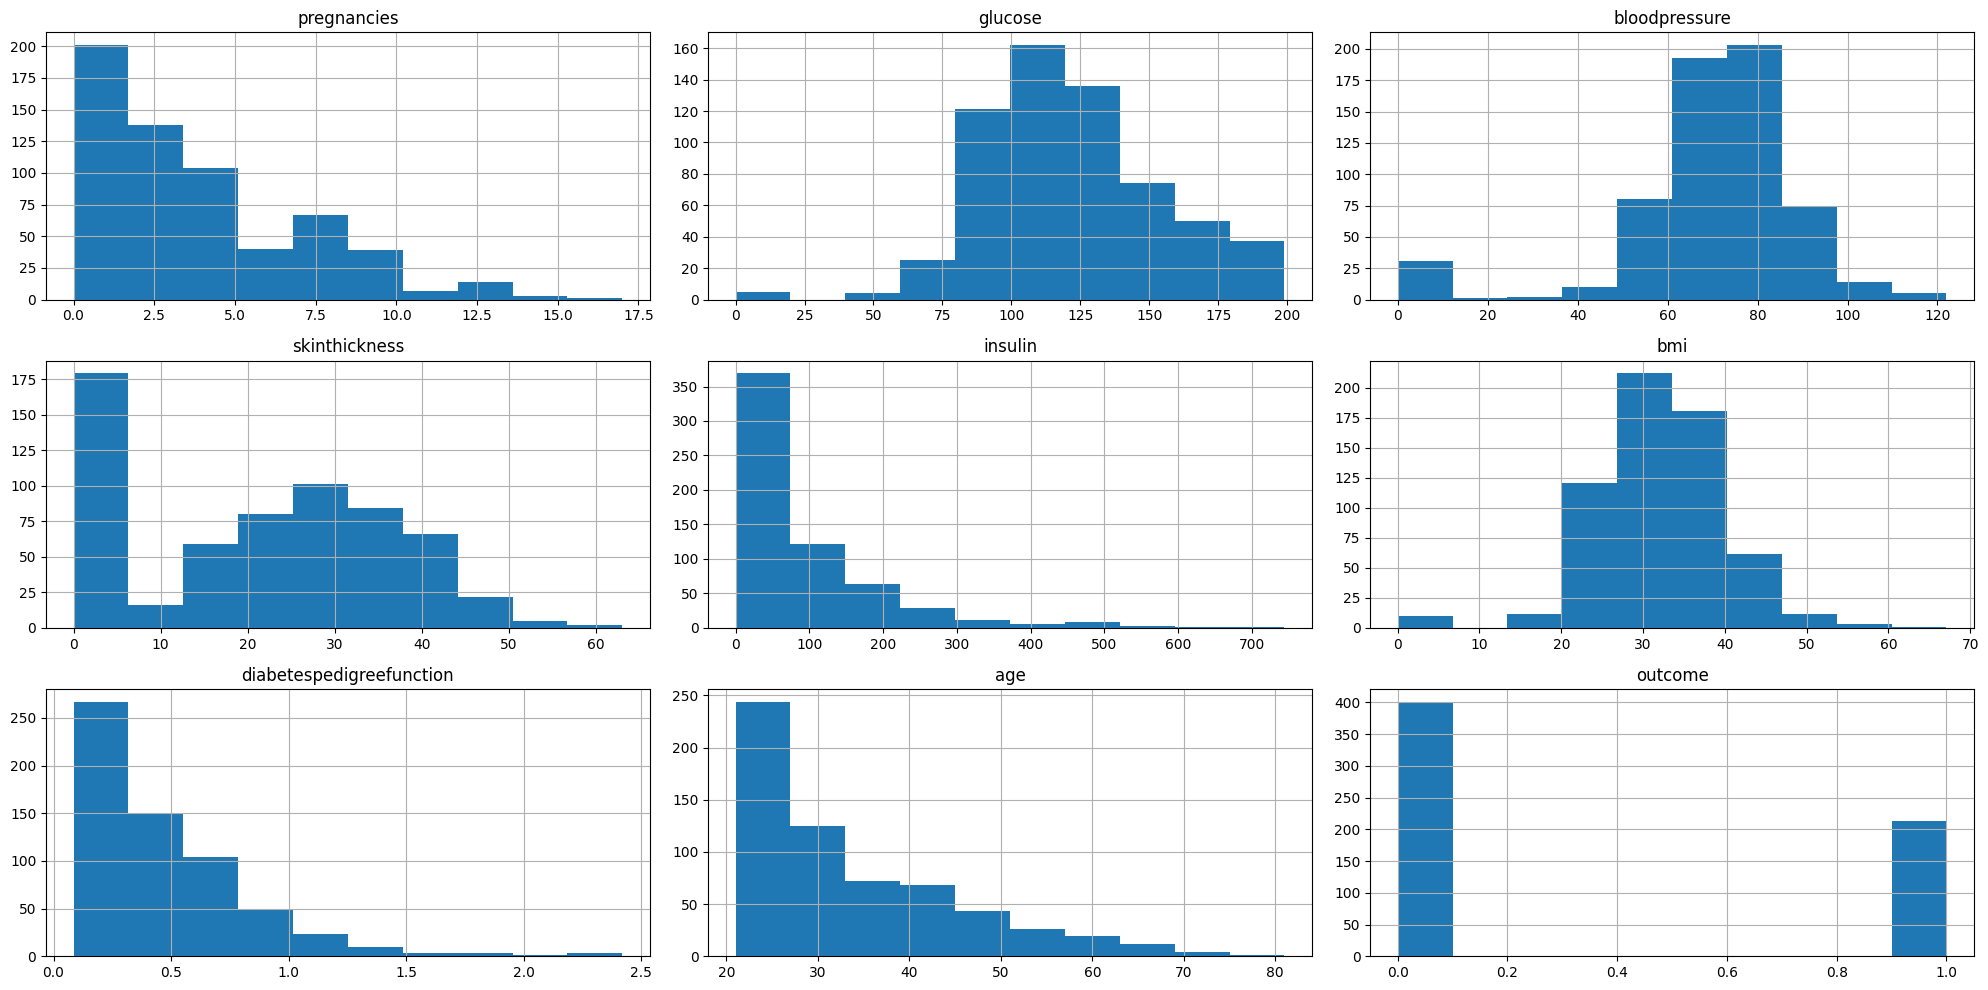

In [46]:
df_train.hist(figsize=(20, 10))
plt.tight_layout()
plt.show()

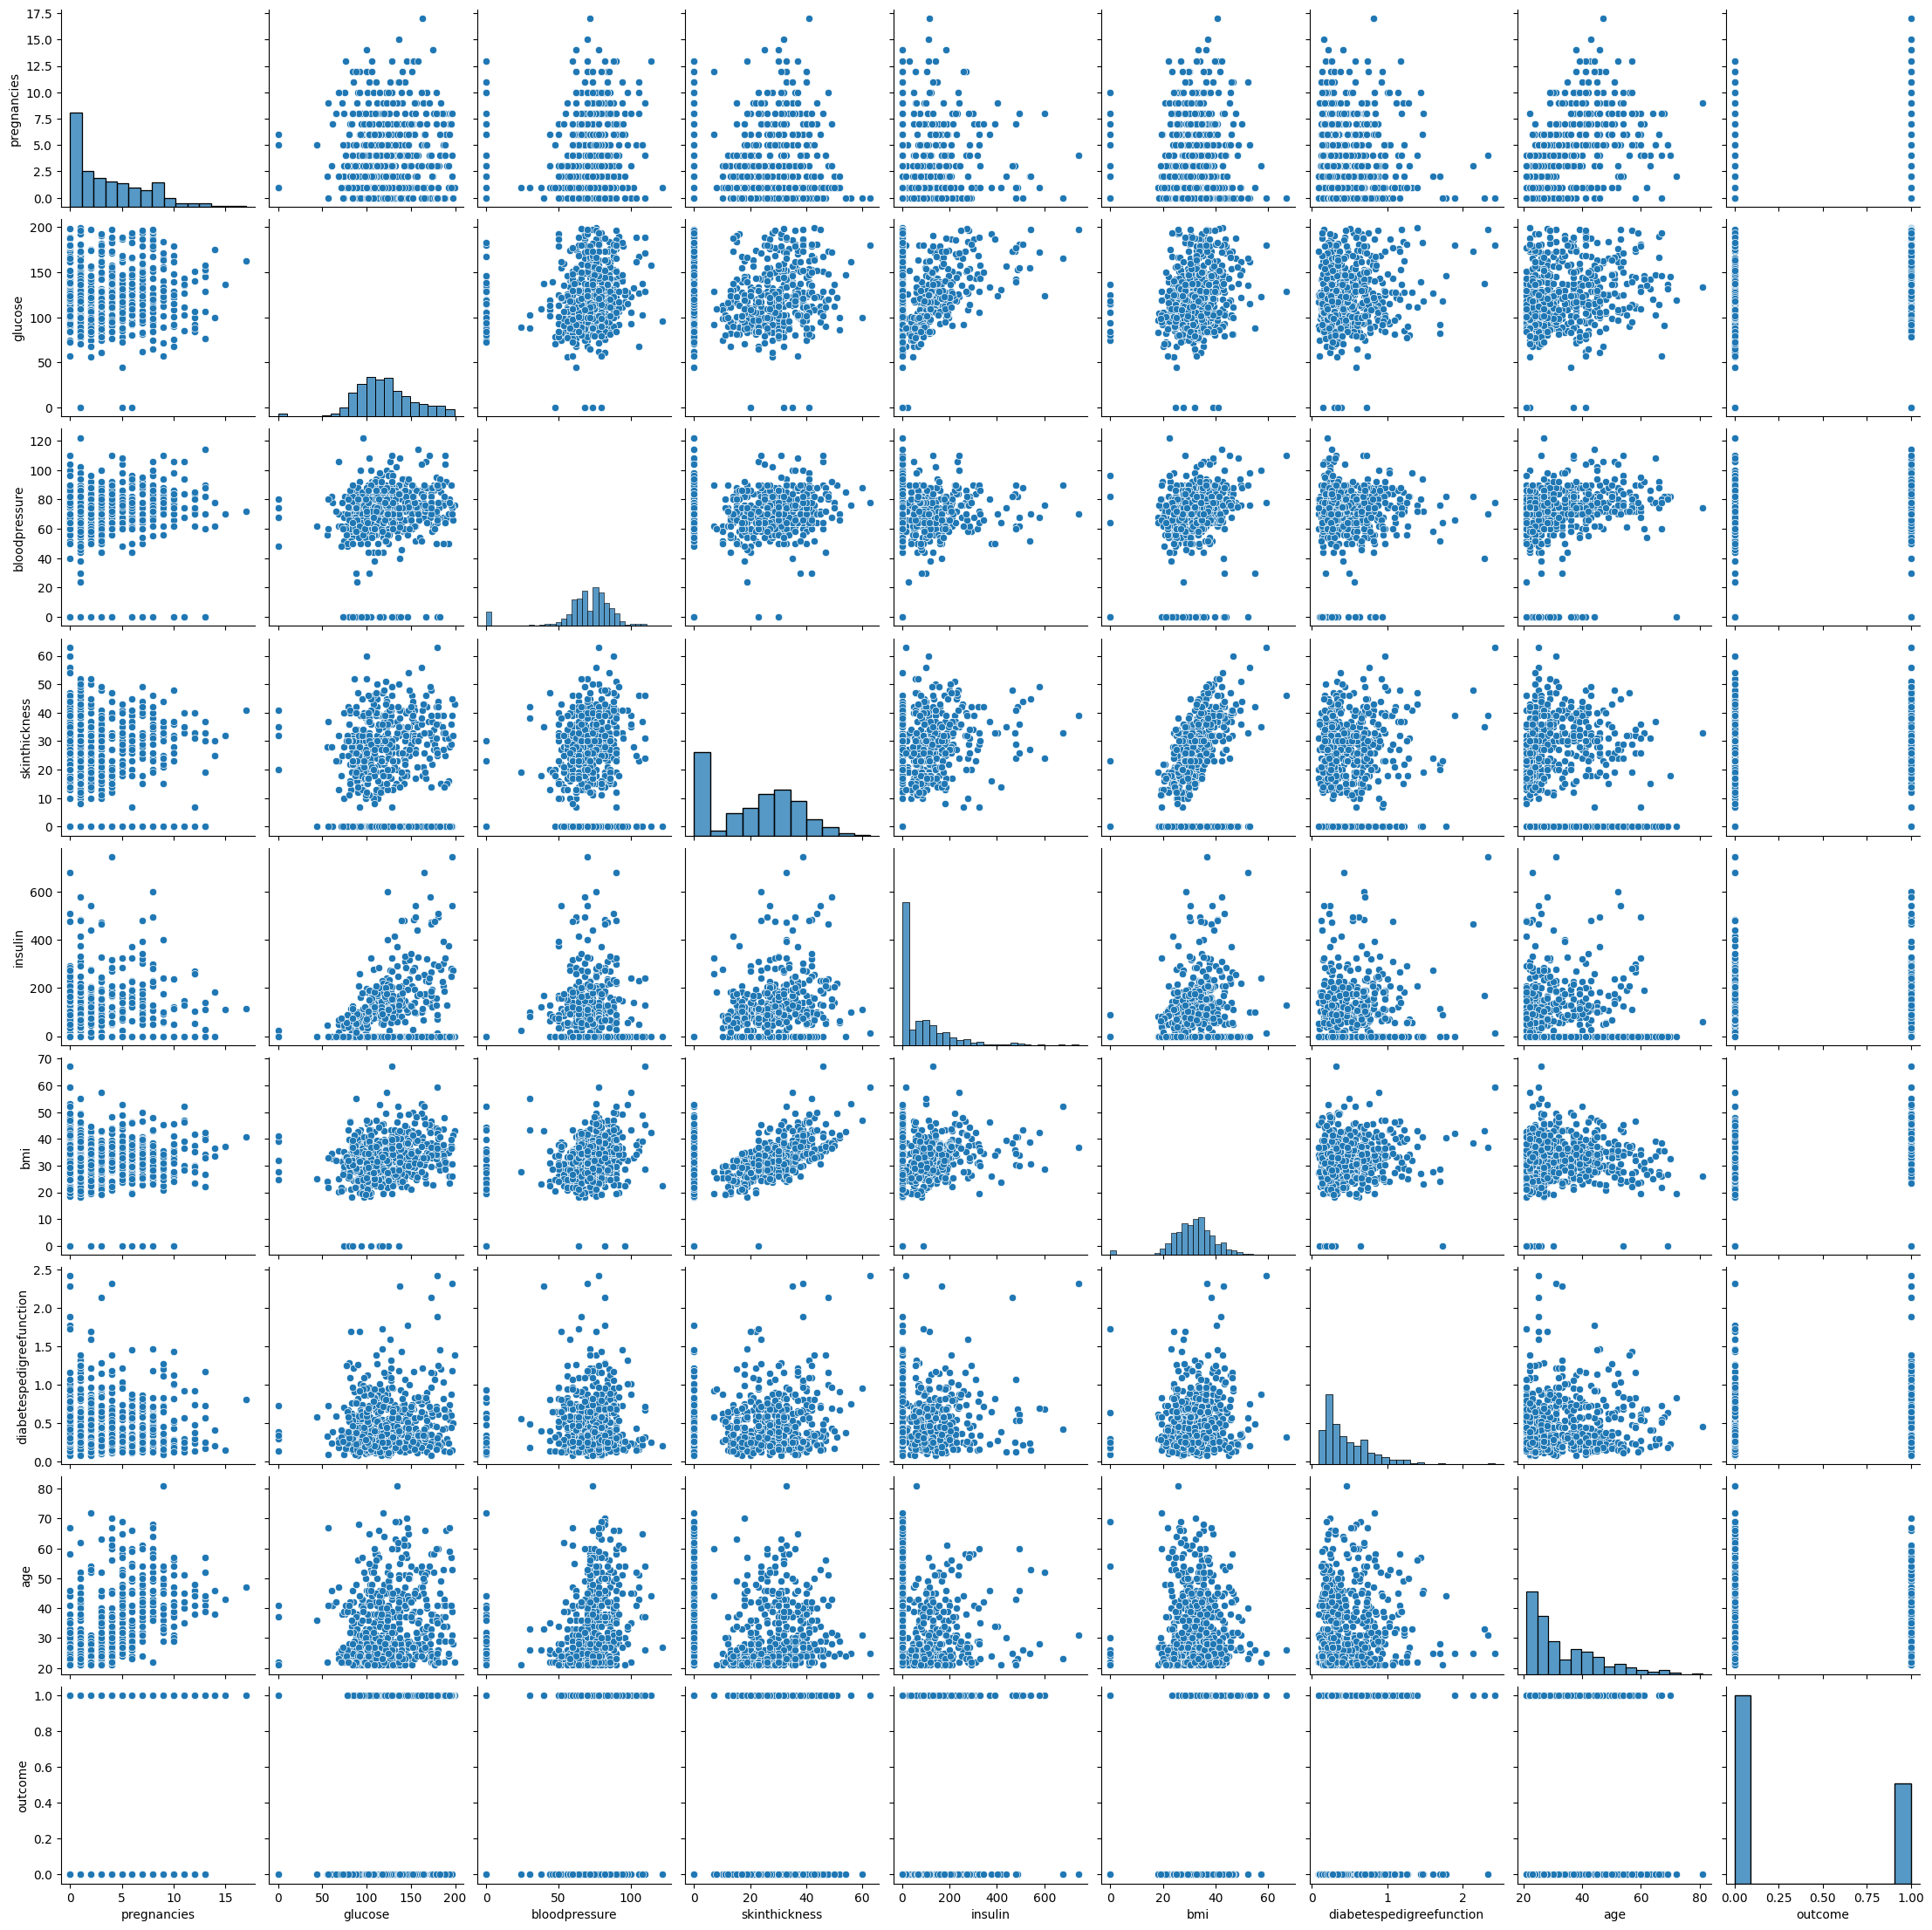

In [49]:
sns.pairplot(data=df_train)
plt.show()

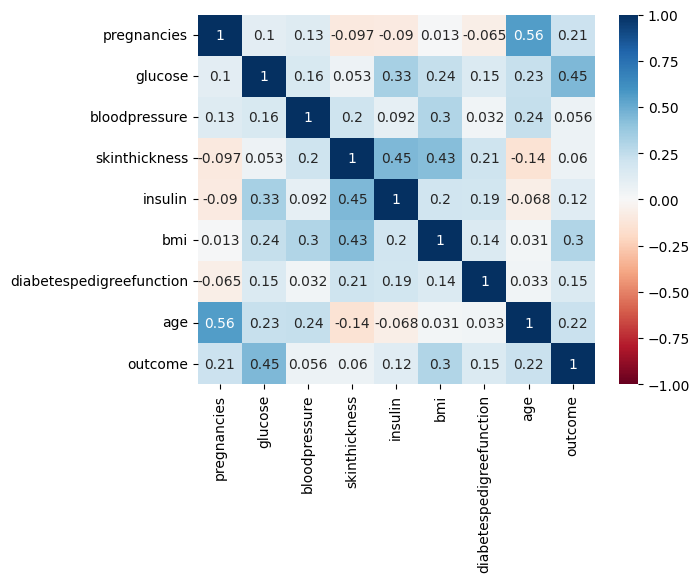

In [50]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap="RdBu")
plt.show()

In [40]:
X = df.drop("Outcome", axis = 1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(k = 7)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,84.0,0.0,0.0,0.0,0.304,21.0
1,9.0,112.0,82.0,0.0,28.2,1.282,50.0
2,1.0,139.0,46.0,83.0,28.7,0.654,22.0
3,0.0,161.0,50.0,0.0,21.9,0.254,65.0
4,6.0,134.0,80.0,370.0,46.2,0.238,46.0


In [11]:
X_test_sel.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,98.0,58.0,190.0,34.0,0.430,43.0
1,2.0,112.0,75.0,0.0,35.7,0.148,21.0
2,2.0,108.0,64.0,0.0,30.8,0.158,21.0
3,8.0,107.0,80.0,0.0,24.6,0.856,34.0
4,7.0,136.0,90.0,0.0,29.9,0.210,50.0


In [12]:
X_train_sel["Outcome"] = y_train.values
X_test_sel["Outcome"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [13]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

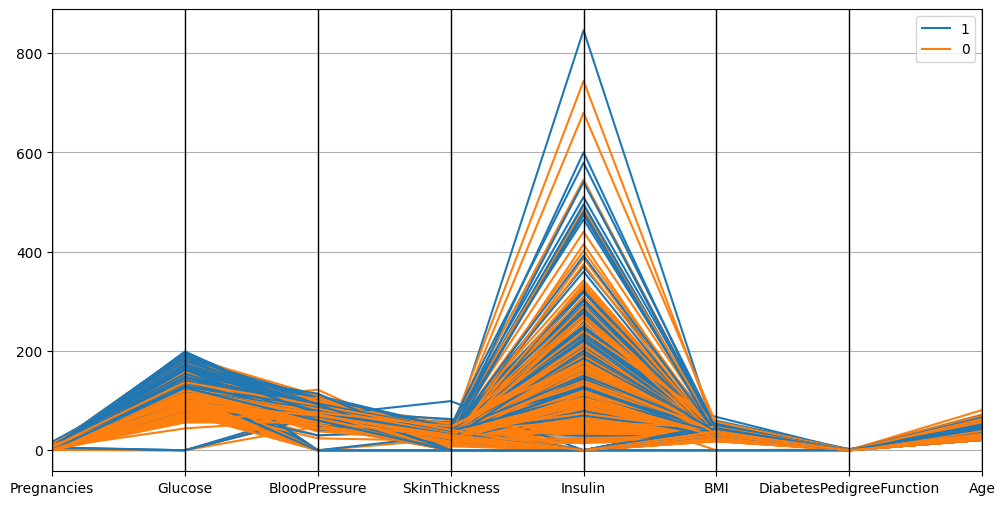

In [15]:
plt.figure(figsize=(12, 6))

pd.plotting.parallel_coordinates(
    total_data, 
    "Outcome", 
    color=("#1f77b4", "#ff7f0e", "#2ca02c")  # Azul, naranja y verde
)

plt.show()


In [16]:
X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

In [17]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

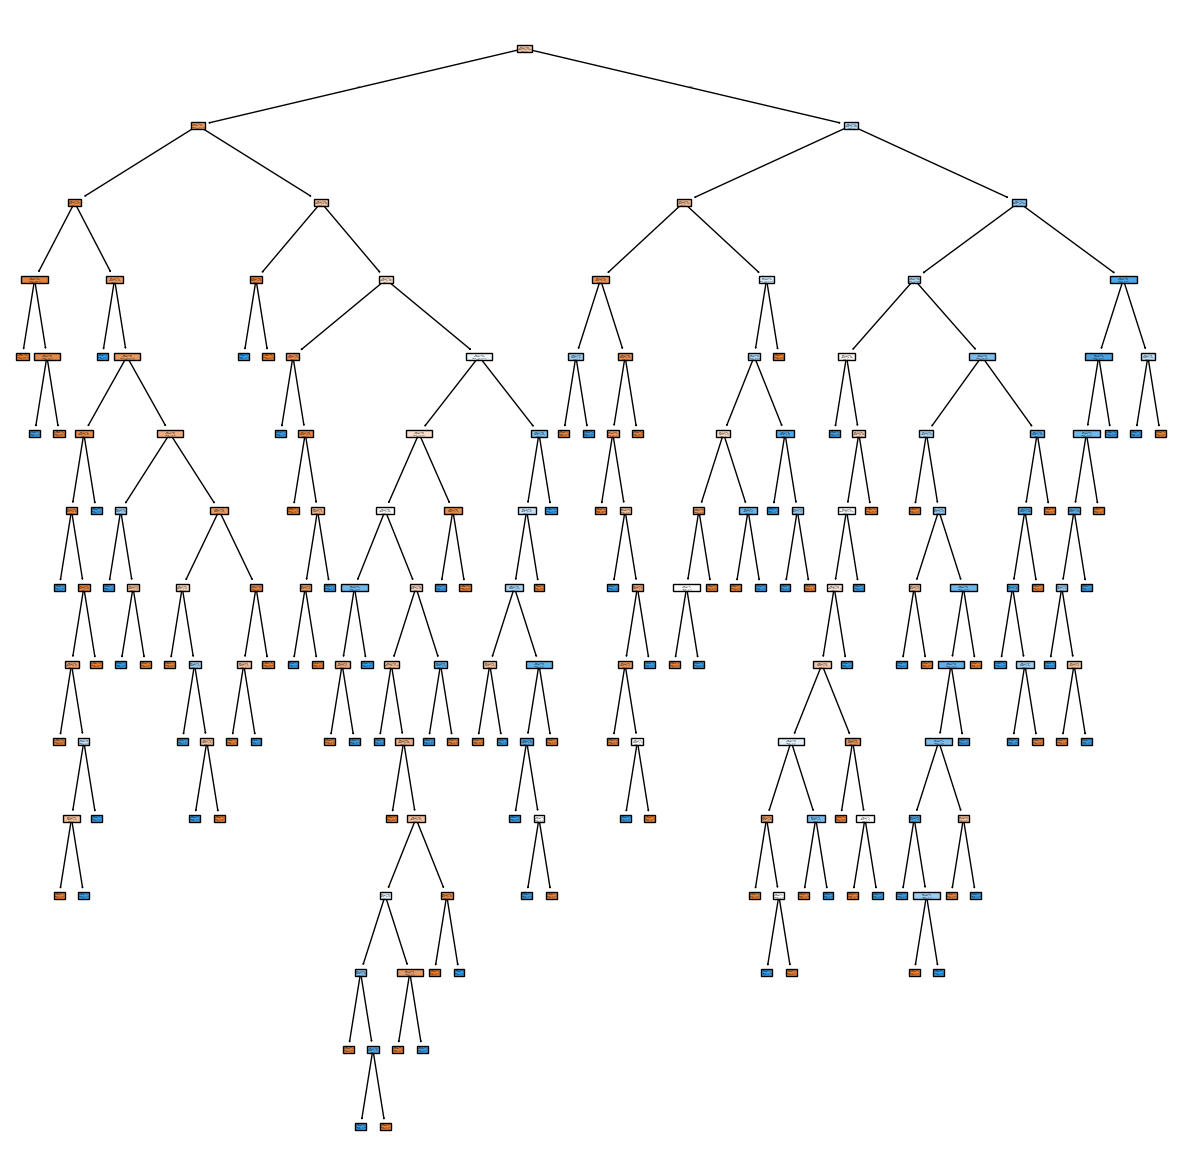

In [18]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

In [19]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [20]:
accuracy_score(y_test, y_pred)

0.7597402597402597

In [21]:
hyperparams = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [26]:
def warn(*args, **kwargs):
    pass
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [27]:
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)

In [28]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
accuracy_score(y_test, y_pred)

0.7727272727272727

In [30]:
dump(model, open("../models/tree_classifier_crit-entro_maxdepth-5_minleaf-4_minsplit2_42.sav", "wb"))